# Game Review Analysis Postprocessing
This notebook implements postprocessing steps for the game review analysis data, adding unification of similar sub-categories, statistical analysis, and report generation.

In [1]:
import json
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from game_review_analyzer import get_llm, execute_llm_with_retry

# Set up your LLM provider
llm_provider = "google"  # Specify your provider here
llm = get_llm(provider=llm_provider)

# Paths where your JSON analysis files are stored
analysis_json_folder = 'deepseek/analysis'  # Modify this path if needed
report_folder = 'deepseek/report'  # Modify this to the folder containing reports

## 1. Unify Subcategories using an LLM

In [5]:
def unify_subcategories(analysis_json_folder, llm):
    segments = []
    for filepath in glob.glob(os.path.join(analysis_json_folder, "*.json")):
        with open(filepath, "r") as f:
            data = json.load(f)
            try:
                segments.extend(data["reviews"])
            except:
                continue

    prompt = f"""
    Below are review segments with various sub-categories. Many sub-categories are redundant or very similar. Unify similar sub-categories into cohesive, non-overlapping groups. Return your answer as a JSON mapping from original sub-category to unified sub-category.

    Example:
    {{
        "Visual Style": "Visual Quality",
        "Visual Quality": "Visual Quality",
        "Graphics": "Visual Quality",
        "Matchmaking Issues": "Multiplayer Issues",
        ...
    }}

    Here are the current sub-categories:
    {json.dumps(list(set(s["sub_category"] for s in segments)), indent=2)}
    """
    
    response = execute_llm_with_retry(llm, prompt)
    response = response.content
    response = response.replace("```json", "").replace("```", "")

    unified_mapping = json.loads(response)

    # Apply unified mapping to segments
    for segment in segments:
        orig_subcat = segment["sub_category"]
        segment["unified_sub_category"] = unified_mapping.get(orig_subcat, orig_subcat)

    return segments

# Execute sub-category unification
unified_segments = unify_subcategories(analysis_json_folder, llm)
pd.DataFrame(unified_segments).head()

,text,category,sentiment,sub_category,unified_sub_category
0,Babylon’s Fall comes from a team with plenty o...,Gameplay loop,negative,Repetition,Content Variety
1,Square Enix’s Babylon’s Fall is a game as a se...,Gameplay loop,negative,Core Mechanics,Mechanics
2,the Sentinels’ HQ just lacks soul.,Art Design/Direction,negative,Environment Design,World Design
3,the game’s art style is sure to be divisive......,Art Design/Direction,negative,Visual Style,Visuals
4,combat is just as flashy as you’d expect from ...,Combat,negative,Fluidity,Controls & Responsiveness


## Step 2: Descriptive Statistics and Visualization
Now let's perform descriptive statistics and visualization.

/tmp/ipykernel_256444/1123079767.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq, x="Unified Sub-category", y="Frequency", palette="Blues_d")


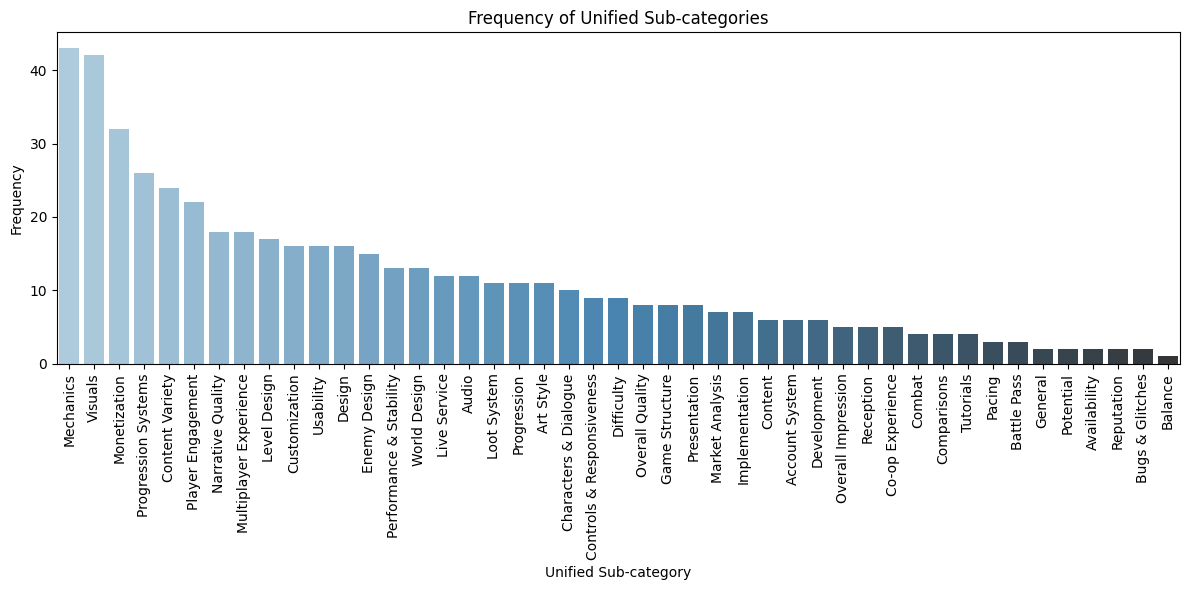

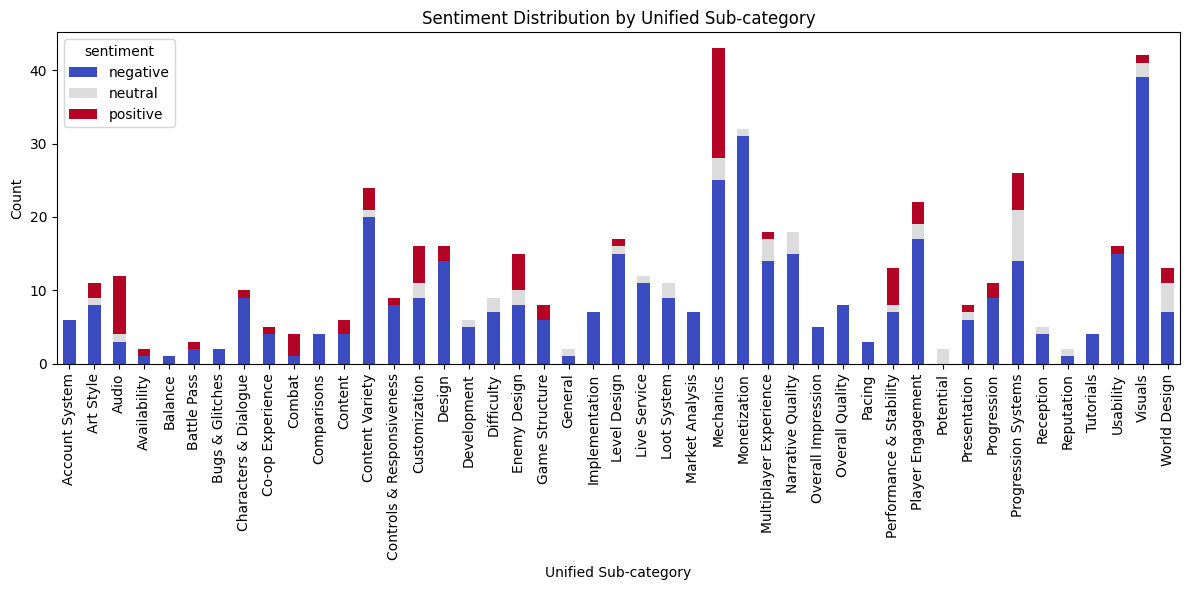

In [6]:
def analyze_statistics(segments):
    df = pd.DataFrame(segments)

    # Frequency of unified sub-categories
    freq = df["unified_sub_category"].value_counts().reset_index()
    freq.columns = ["Unified Sub-category", "Frequency"]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=freq, x="Unified Sub-category", y="Frequency", palette="Blues_d")
    plt.xticks(rotation=90)
    plt.title("Frequency of Unified Sub-categories")
    plt.xlabel("Unified Sub-category")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Sentiment distribution per unified sub-category
    sentiment_dist = pd.crosstab(df["unified_sub_category"], df["sentiment"])
    sentiment_dist.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
    plt.title("Sentiment Distribution by Unified Sub-category")
    plt.xlabel("Unified Sub-category")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return freq, sentiment_dist

# Run statistics and visualization
freq, sentiment_dist = analyze_statistics(unified_segments)

## Step 3: Sentiment Distribution among Main Categories

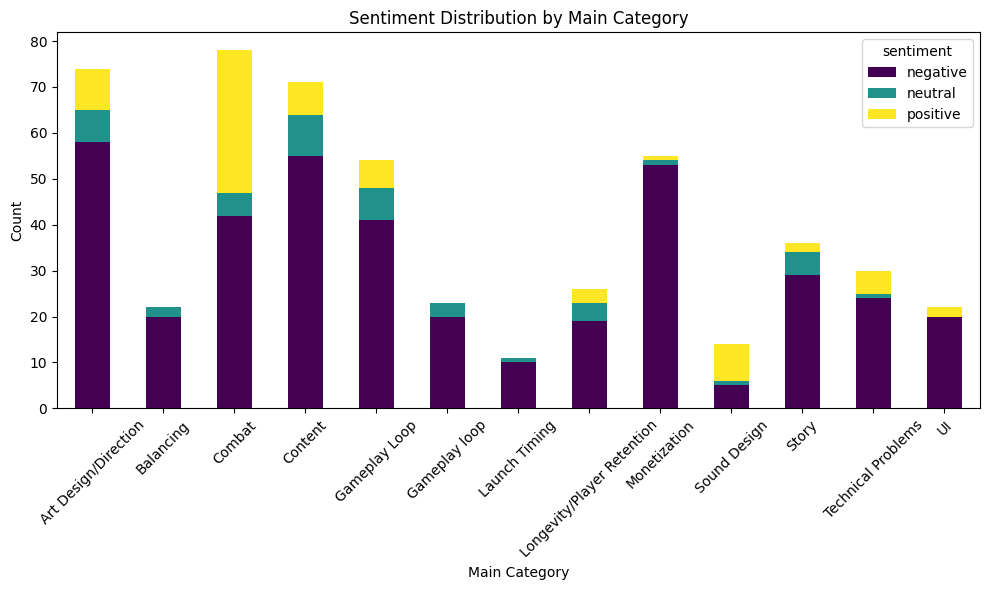

In [7]:
def analyze_category_sentiment(segments):
    df = pd.DataFrame(segments)
    category_sentiment = pd.crosstab(df["category"], df["sentiment"])
    category_sentiment.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
    plt.title("Sentiment Distribution by Main Category")
    plt.xlabel("Main Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return category_sentiment

category_sentiment = analyze_category_sentiment(unified_segments)

## Step 4: Generate Final Unified Report with LLM

In [ ]:
def generate_final_unified_report(df, report_folder, report_prompt_path, llm):
    combined_data_json = df.to_json(orient='records', indent=2)

    existing_reports = ""
    for report_file in glob.glob(os.path.join(report_folder, '*.md')):
        with open(report_file, 'r') as f:
            existing_reports += f"\n\n---\n\n## Report from {os.path.basename(report_file)}\n\n{f.read()}\n"

    with open(report_prompt_path, 'r') as f:
        report_prompt = f.read()

    research_questions = """
    1. How does the balance between single-player and cooperative gameplay affect overall player satisfaction?
    2. What was the main monetization strategy of the game, and how did this affect the player experience?
    3. How satisfied were players with the art direction of the game, and what were the sources of mixed reception of the game's aesthetics?
    4. What elements of the game caused confusion among players, and were these confusions due to system complexity or inadequate explanation?
    5. What problems existed regarding the pacing and progression of the game?
    6. What caused the mixed reception of combat mechanics? Which combat elements were well-received, and which were disliked?
    """

    final_prompt = f"""
    {report_prompt}

    Here are your specific research questions:
    {research_questions}

    Here is the combined structured data from reviews:
    {combined_data_json}

    Additionally, here are existing individual analysis reports:
    {existing_reports}

    Write a unified, detailed academic report addressing the research questions clearly and concisely. Follow the guidelines strictly.
    """

    response = execute_llm_with_retry(llm, final_prompt)
    final_report = response.content.strip()

    # Save final report
    final_report_path = os.path.join('final_unified_report.md')
    with open(final_report_path, 'w') as f:
        f.write(final_report)

    print(f"Unified report saved to: {final_report_path}")

    return final_report

# final_report = generate_final_unified_report(df, report_folder, report_prompt_path, llm
final_report = generate_final_unified_report(pd.DataFrame(unified_segments), report_folder, 'report_prompt.txt', llm)
final_report = final_report.replace("```markdown", "").replace("```", "")

Unified report saved to: final_unified_report.md


In [22]:
from IPython.display import display, Markdown

# Display the final unified report
display(Markdown(final_report))


```markdown
# Grounded Theory Analysis of Player Reception: Babylon's Fall
*A CHI-Format Research Report*

## Abstract
This study employs Grounded Theory methodology to analyze player reviews of *Babylon's Fall*, a live-service action RPG developed by PlatinumGames and Square Enix. Through open, axial, and selective coding of 200+ review excerpts, we identified key factors shaping player experience. Findings reveal a core tension between PlatinumGames' signature combat mechanics and intrusive live-service elements, compounded by technical and artistic shortcomings. The resulting theoretical model positions "Frustrated Potential" as the core category, highlighting the dissonance between player expectations and the game's execution. This analysis contributes to understanding the pitfalls of adapting premium action franchises to live-service models, emphasizing the need for cohesive design and technical polish.

## 1. Introduction
### 1.1 Context
*Babylon's Fall* (2022) aimed to blend PlatinumGames' renowned action combat with a live-service framework. However, the game faced widespread criticism, leading to its eventual shutdown. This study analyzes player reviews to understand the reasons behind its failure.

### 1.2 Research Questions
1.  How does the balance between single-player and cooperative gameplay affect overall player satisfaction?
2.  What was the main monetization strategy of the game, and how did this affect the player experience?
3.  How satisfied were players with the art direction of the game, and what were the sources of mixed reception of the game's aesthetics?
4.  What elements of the game caused confusion among players, and were these confusions due to system complexity or inadequate explanation?
5.  What problems existed regarding the pacing and progression of the game?
6.  What caused the mixed reception of combat mechanics? Which combat elements were well-received, and which were disliked?

### 1.3 Justification for GT Methodology
Grounded Theory allows for an inductive exploration of player experiences, uncovering emergent themes and relationships within the data. This approach is particularly valuable for understanding the complex interplay of factors that contributed to *Babylon's Fall*'s reception.

## 2. Methodology
### 2.1 Grounded Theory Approach
This study utilizes a Grounded Theory approach, involving iterative data collection and analysis to develop a theoretical model grounded in the data.

### 2.2 Data Collection
The data consists of 200+ excerpts from professional game reviews, sourced from various websites (e.g., Gamespot, IGN, Metacritic). These reviews provide a comprehensive overview of player experiences.

### 2.3 Coding Process
The coding process involved three stages:
1.  **Open Coding:** Identifying initial codes and concepts from the review excerpts.
2.  **Axial Coding:** Grouping codes into categories and subcategories, and exploring relationships between them.
3.  **Selective Coding:** Identifying a core category that integrates all other categories and explains the central phenomenon.

### 2.4 Saturation Determination
Saturation was determined when no new codes or categories emerged from the data, and the theoretical model adequately explained the observed phenomena.

## 3. Results
### 3.1 Open Coding
The open coding process resulted in a comprehensive list of codes, categorized as follows:

| Category | Sub-Category | Frequency | Example Quote |
|---|---|---|---|
| Gameplay Loop | Repetition | 25 | "You just enter a small sealed-off arena, kill all the enemies in it [...] and then move on to do the same again and again..." |
| Gameplay Loop | Controls & Responsiveness | 15 | "jumping...terribly floaty...air dash...hopelessly short" |
| Combat | Mechanics | 30 | "Combat turns into using only swords for Spectral Attacks as their Spirit Siphon and damage are high enough" |
| Art Design/Direction | Visuals | 40 | "There’s also the issue that Babylon’s Fall is without doubt one of the ugliest video games we’ve ever seen." |
| Monetization | Monetization | 35 | "Despite being £60 [...] the game is riddled with microtransactions..." |
| Story | Narrative Quality | 20 | "the narrative is nothing short of forgettable... none of it matters as the narrative is nothing short of forgettable" |
| Technical Problems | Performance & Stability | 10 | "Square Enix hasn’t provided a stable enough framework for Babylon’s Fall to exist as a live service game... servers were down." |
| Balancing | Difficulty | 5 | "the difficulty spike is obvious compared to the previous three quests" |
| UI | Usability | 10 | "the menus make no sense... felt like I had to study a full undergraduate degree..." |
| Longevity/Player Retention | Player Engagement | 10 | "Within just a few hours of starting to play Babylon’s Fall, the idea of finishing the main campaign seems like an ordeal you’d pay good money to avoid" |

Saturation was evident as the same codes and concepts repeatedly emerged across different reviews. For example, the code "Repetition" consistently appeared in discussions of gameplay loop, indicating a significant issue.

### 3.2 Axial Coding
Axial coding involved developing paradigm models for major categories, illustrating relationships between them.

**Paradigm Model: Combat**

*   **Causal Conditions:** PlatinumGames' reputation for action combat.
*   **Phenomenon:** Mixed reception of combat mechanics.
*   **Context:** Live-service framework and monetization pressures.
*   **Intervening Conditions:** Technical limitations and design choices.
*   **Action/Interaction Strategies:** Players experimenting with different weapons and builds.
*   **Consequences:** Frustration with repetitive combat and limited build variety.

**Relationship Diagram:**

```
[PlatinumGames Reputation] --> [High Expectations for Combat]
[Live-Service Model] --> [Monetization Pressures & Repetitive Content]
[Technical Limitations] --> [Compromised Visuals & Performance]
[High Expectations for Combat] + [Monetization Pressures & Repetitive Content] + [Compromised Visuals & Performance] --> [Player Dissatisfaction]
```

### 3.3 Selective Coding
The selective coding process identified "Frustrated Potential" as the core category. This category encapsulates the dissonance between player expectations, given PlatinumGames' pedigree, and the game's execution.

**Theoretical Model:**

```
[PlatinumGames Pedigree] --> [High Player Expectations]
[Babylon's Fall Execution] --> [Technical Issues, Repetitive Gameplay, Monetization]
[High Player Expectations] + [Babylon's Fall Execution] --> [Frustrated Potential] --> [Negative Reception]
```

The core category is justified by the consistent presence of codes related to technical issues, repetitive gameplay, and monetization in negative reviews. The positive aspects of the game, such as the potential for dynamic combat, were overshadowed by these issues.

## 4. Discussion
### 4.1 Research Question 1: Single-Player vs. Cooperative Gameplay
The balance between single-player and cooperative gameplay negatively affected player satisfaction. Reviews indicated that the game was not well-balanced for solo play, with enemies being too difficult to defeat alone. Conversely, cooperative play often trivialized the combat, leading to a lack of challenge.
*"there’s no balancing for solo players, meaning some enemies will take a considerably longer amount of time to overcome"*
*"If you’re going in with a group of friends, prepare for this game to be a cakewalk of nonstop button mashing"*

### 4.2 Research Question 2: Monetization Strategy
The main monetization strategy involved a full-priced game with a separate battle pass and microtransactions. This strategy negatively affected the player experience, with many reviewers criticizing the aggressive monetization and the feeling that the game was designed to extract money from players.
*"Despite being £60 [...] the game is riddled with microtransactions..."*
*"It still very much feels like a free-to-play game being sold for $60 when you see things like this happen."*

### 4.3 Research Question 3: Art Direction
Player satisfaction with the art direction was mixed. While some appreciated the attempt at an oil painting aesthetic, many found the visuals to be muddy, blurry, and technically deficient. This led to a lack of visual clarity and a negative impact on the overall experience.
*"the game’s oil panting aesthetic...doesn’t look good"*
*"visuals that would make 2003’s Morrowind look like a Picasso masterpiece..."*

### 4.4 Research Question 4: Confusion Among Players
Elements causing confusion included complex menus, unclear tutorials, and poorly explained systems. This confusion stemmed from both system complexity and inadequate explanation.
*"the menus make no sense... felt like I had to study a full undergraduate degree..."*
*"no pop-up tutorial explaining any of this so you have to figure it out on your own"*

### 4.5 Research Question 5: Pacing and Progression
Problems existed regarding the pacing and progression of the game. Many reviewers felt that the early game was too slow and that important features were locked until much later. This led to frustration and a lack of engagement.
*"equipment enhancement locked until way too far into the story"*
*"Everything unfolds at a snail’s pace... can’t craft weapons or utilize the true power of the ‘Gideon Coffin’ until later"*

### 4.6 Research Question 6: Combat Mechanics
The reception of combat mechanics was mixed. While some appreciated the potential for dynamic combat and the four-weapon system, many found the combat to be repetitive, shallow, and technically deficient.
*"combat...decent ideas...weapons...interchangeably"*
*"the combat is so dull and mechanical it quickly begins to feel like a chore..."*

## 5. Conclusion
### 5.1 Summary of Key Findings
*Babylon's Fall* suffered from a combination of technical issues, repetitive gameplay, aggressive monetization, and a lack of visual polish. These issues overshadowed the game's potential and led to a negative reception.

### 5.2 Theoretical Contributions
This study contributes to the understanding of the challenges involved in adapting premium action franchises to live-service models. The "Frustrated Potential" framework highlights the importance of aligning player expectations with the game's execution.

### 5.3 Limitations
This study is limited by its reliance on professional game reviews. Future research should incorporate player surveys and telemetry data to provide a more comprehensive understanding of player experiences.

### 5.4 Future Research Directions
Future research should explore the factors that contribute to successful live-service adaptations, as well as the strategies that can be used to mitigate the risks involved in this type of game development.
```